<a href="https://colab.research.google.com/github/vanithakattumuri/PAMI/blob/main/notebooks/Apriori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding frequent patterns in transactional databases using Apriori

This tutorial has two parts. In the first part, we describe the basic approach to find frequent patterns in a transactional database using the Apriori algorithm. In the final part, we describe an advanced approach, where we evaluate the Apriori algorithm on a dataset at different minimum support threshold values.
***

# Prerequisites:



1.   Installing the PAMI library





In [1]:
!pip install pami==2023.7.7 #install the pami repository

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.8/784.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19580 sha256=7cf142b12197c94d1877f71b7334145163ae73d1e7303a26f730d6cfb4053848
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
  Created wheel for JsonForm: filename=JsonForm-0.0.2-py3-none-any.whl size=3310 sha256=27f63aa224faf8ca488412f6b0f6e059f3320f5f01555a4e5fd0f91bac2d1e99
  Stored in directory: /root/.cache/pip/wheels/b6/e5/87/11026246d3bd4ad67c0615682d2d6748bbd9a40ac0490882bd
  Created wheel for JsonSir: filename=JsonSir-0.0.2-py3-none-any.whl size=4750 sha256=26a8f76c5fb5ffe968662211e9cbda2ea4643c5fad20dc6cb72bb1480b9cfba5
  Stored in directory: /root/.cache/pip/wheels/1d/4c/d3/4d9757425983b43eb709be1043d82cd03fb863ce5f56f117e6
Successfully



2.   Downloading a sample dataset




In [2]:
!wget -nc https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv #download a sample transactional database

--2023-07-28 10:43:38--  https://u-aizu.ac.jp/~udayrage/datasets/transactionalDatabases/Transactional_T10I4D100K.csv
Resolving u-aizu.ac.jp (u-aizu.ac.jp)... 150.31.244.160, 150.95.161.176
Connecting to u-aizu.ac.jp (u-aizu.ac.jp)|150.31.244.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4019277 (3.8M) [text/csv]
Saving to: ‘Transactional_T10I4D100K.csv’

Transactional_T10I4 100%[===================>]   3.83M   882KB/s    in 6.6s    

2023-07-28 10:43:46 (597 KB/s) - ‘Transactional_T10I4D100K.csv’ saved [4019277/4019277]





3.   Printing few lines of a dataset to know its format.




In [3]:
!head -2 Transactional_T10I4D100K.csv

25	52	164	240	274	328	368	448	538	561	630	687	730	775	825	834
39	120	124	205	401	581	704	814	825	834


format: every row contains items seperated by a seperator.

Example:

item1 item2 item3 item4

item1 item4 item6
***

## Part 1: Finding frequent patterns using Apriori

### Step 1: Understanding the statistics of a database to choose an appropriate minimum support (minSup) value.

In [4]:
#import the class file
import PAMI.extras.dbStats.transactionalDatabaseStats as stats

#specify the file name
inputFile = 'Transactional_T10I4D100K.csv'

#initialize the class
obj=stats.transactionalDatabaseStats(inputFile,sep='\t')

#execute the class
obj.run()

#Printing each of the database statistics
print(f'Database size : {obj.getDatabaseSize()}')
print(f'Total number of items : {obj.getTotalNumberOfItems()}')
print(f'Database sparsity : {obj.getSparsity()}')
print(f'Minimum Transaction Size : {obj.getMinimumTransactionLength()}')
print(f'Average Transaction Size : {obj.getAverageTransactionLength()}')
print(f'Maximum Transaction Size : {obj.getMaximumTransactionLength()}')
print(f'Standard Deviation Transaction Size : {obj.getStandardDeviationTransactionLength()}')
print(f'Variance in Transaction Sizes : {obj.getVarianceTransactionLength()}')

#saving the distribution of items' frequencies and transactional lengths
itemFrequencies = obj.getSortedListOfItemFrequencies()
transactionLength = obj.getTransanctionalLengthDistribution()
obj.save(itemFrequencies, 'itemFrequency.csv')
obj.save(transactionLength, 'transactionSize.csv')

#Alternative apporach to print all of the database statistics and plot them
# obj.printStats()
# obj.plotGraphs()

Database size : 99935
Total number of items : 870
Database sparsity : 0.9883886940304302
Minimum Transaction Size : 1
Average Transaction Size : 10.101836193525791
Maximum Transaction Size : 29
Standard Deviation Transaction Size : 3.667097909135199
Variance in Transaction Sizes : 13.447741640067324


### Step 2: Draw the item's frequency graph and transaction length's distribution graphs for more information

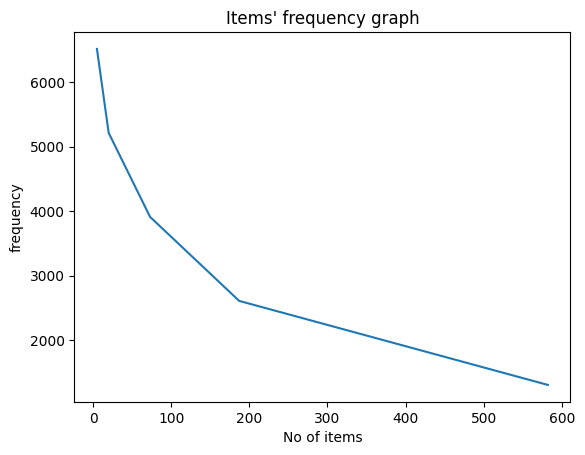

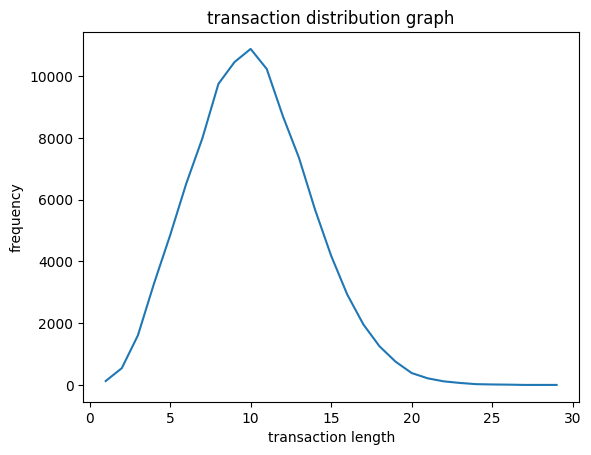

In [5]:
import PAMI.extras.graph.plotLineGraphFromDictionary as plt

itemFrequencies = obj.getFrequenciesInRange()
transactionLength = obj.getTransanctionalLengthDistribution()
plt.plotLineGraphFromDictionary(itemFrequencies, 100, 'Items\' frequency graph', 'No of items', 'frequency')
plt.plotLineGraphFromDictionary(transactionLength, 100, 'transaction distribution graph', 'transaction length', 'frequency')

### Step 3: Choosing an appropriate *minSup* value

_Observations_

  1. The input dataset is sparse as the sparsity value is 0.988 (=98.8%)
  2. Many items have low frequencies as seen in the items' frequency graph
  3. The dataset is not high dimensional as the inverted curve is around 10.

  Based on the above observations, let us choose a _minSup_ value of 1000 (in count). We can increase or decrease the _minSup_ based on the number of patterns being generated.

In [6]:
minSup=1000 #minSup is specified in count. However, the users can also specify minSup between 0 and 1.

### Step 4: Mining frequent patterns using Apriori

In [7]:
from PAMI.frequentPattern.basic import Apriori as alg #import the algorithm

obj = alg.Apriori(iFile=inputFile, minSup=minSup, sep='\t')    #initialize
obj.startMine()            #start the mining process

obj.save('frequentPatternsAtMinSupCount1000.txt') #save the patterns


frequentPatternsDF= obj.getPatternsAsDataFrame() #get the generated frequent patterns as a dataframe
print('Total No of patterns: ' + str(len(frequentPatternsDF))) #print the total number of patterns
print('Runtime: ' + str(obj.getRuntime())) #measure the runtime

print('Memory (RSS): ' + str(obj.getMemoryRSS()))
print('Memory (USS): ' + str(obj.getMemoryUSS()))

Frequent patterns were generated successfully using Apriori algorithm 
Total No of patterns: 385
Runtime: 940.5112044811249
Memory (RSS): 298651648
Memory (USS): 251838464


### Step 5: Investigating the generated patterns

Open the pattern's file and investigate the generated patterns. If the generated patterns were interesting, use them; otherwise, redo the Steps 3 and 4 with a different _minSup_ value.

In [8]:
!head frequentPatternsAtMinSupCount1000.txt

240:1398 
25:1391 
274:2626 
368:7821 
448:1368 
52:1979 
538:3981 
561:2783 
630:1521 
687:1761 


The storage format is: _frequentPattern:support_
***

## Part 2: Evaluating the Apriori algorithm on a dataset at different minSup values

### Step 1: Import the libraries and specify the input parameters

In [ ]:
#Import the libraries
from PAMI.frequentPattern.basic import Apriori as alg #import the algorithm
import pandas as pd

#Specify the input parameters
inputFile = 'Transactional_T10I4D100K.csv'
seperator='\t'
minimumSupportCountList = [1000, 1500, 2000, 2500, 3000]
#minimumSupport can also specified between 0 to 1. E.g., minSupList = [0.005, 0.006, 0.007, 0.008, 0.009]

### Step 2: Create a data frame to store the results of Apriori

In [10]:
result = pd.DataFrame(columns=['algorithm', 'minSup', 'patterns', 'runtime', 'memory'])
#initialize a data frame to store the results of Apriori algorithm

### Step 3: Execute the algorithm at different minSup values

In [11]:
for minSupCount in minimumSupportCountList:
    obj = alg.Apriori(inputFile, minSup=minSupCount,sep=seperator)
    obj.startMine()
    #store the results in the data frame
    result.loc[result.shape[0]] = ['Apriori', minSupCount, len(obj.getPatterns()), obj.getRuntime(), obj.getMemoryRSS()]

Frequent patterns were generated successfully using Apriori algorithm 
Frequent patterns were generated successfully using Apriori algorithm 
Frequent patterns were generated successfully using Apriori algorithm 
Frequent patterns were generated successfully using Apriori algorithm 
Frequent patterns were generated successfully using Apriori algorithm 


### Step 4: Print the Result

In [12]:
print(result)

  algorithm  minSup  patterns     runtime     memory
0   Apriori    1000       385  956.046366  299646976
1   Apriori    1500       237  319.801223  299872256
2   Apriori    2000       155  126.555804  300900352
3   Apriori    2500       107   62.703307  300490752
4   Apriori    3000        60   26.466549  299425792


### Step 5: Visualizing the results

<Axes: xlabel='minSup'>

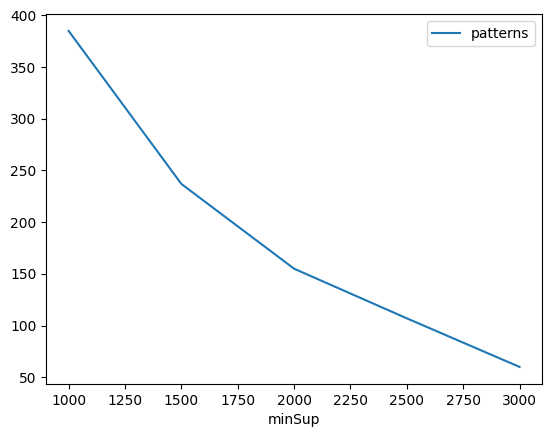

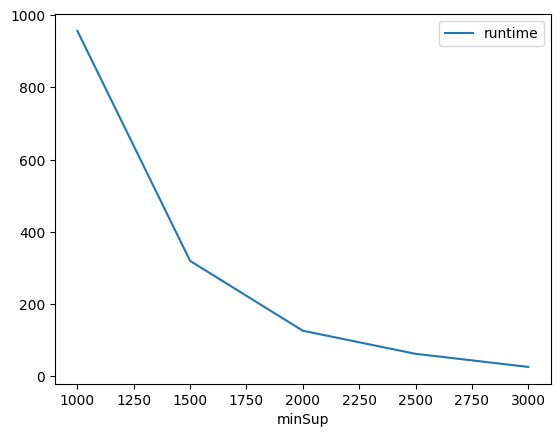

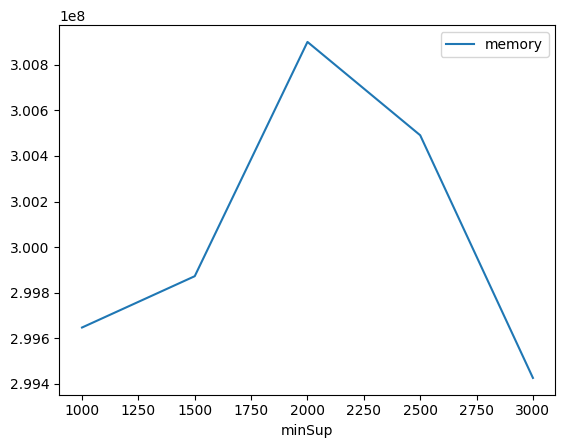

In [13]:
result.plot(x='minSup', y='patterns', kind='line')
result.plot(x='minSup', y='runtime', kind='line')
result.plot(x='minSup', y='memory', kind='line')

#Graphs can be improved further by using additional packages, such as plotly and matplotlib